# MNIST

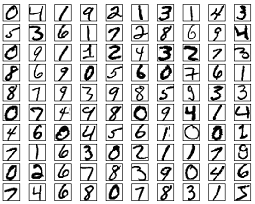

0~9 까지 10개 숫자의 손글씨 데이터

# 1. DNN(MLP)를 활용한 MNIST 판별모델  

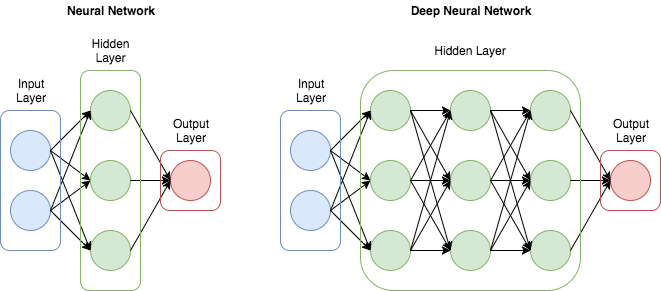

## 1.1 단순 모듈 활용

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
import numpy as np

In [ ]:
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

learning_rate = 0.01
training_steps = 3000
batch_size = 200
epochs = 10
display_step = 300 ## 1epoch 마다 show

Epoch
  - 전체 sample 데이터를 한 바퀴 돌며 학습하는 것, 1 epoch

Step
  - 1개의 배치로부터 loss를 계산한 후 Weight와 Bias를 1회 업데이트하는 것, 1 Step

Batch Size
  - 1 Step에서 사용한 데이터 개수
  
  
  
  

```
관련 수식
n * e = s * b
```



n = num of sample : 전체 학습할 데이터(training examples)의 개수

e = epochs: Epoch 수

b = batch size: 배치 사이즈

s = steps: Step 수

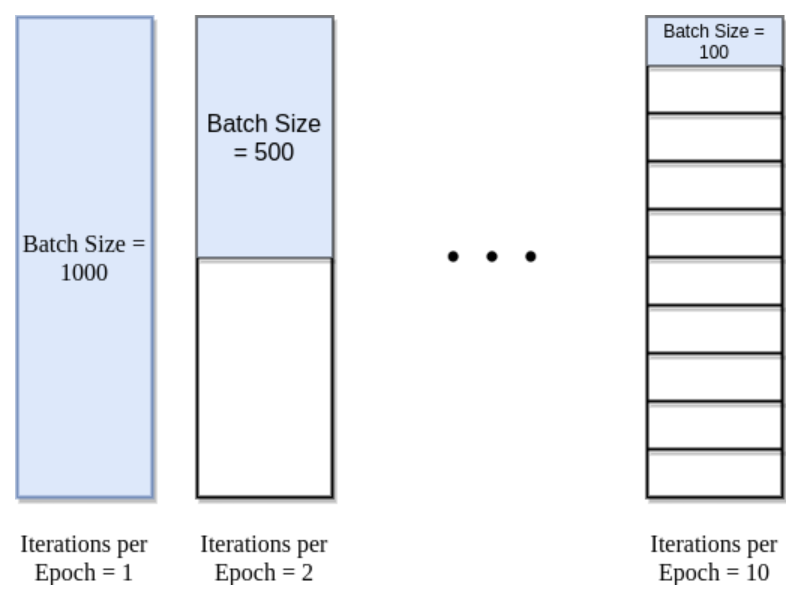

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='sigmoid'),  # hidden layer (1)
    keras.layers.Dense(256, activation='sigmoid'),  # hidden layer (2)
    keras.layers.Dense(10, activation='softmax') # output layer (3)
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, shuffle=True, use_multiprocessing=True)

Epoch 1/10
300/300 [==============================] - 3s 2ms/step - loss: 0.7992 - accuracy: 0.7865
Epoch 2/10
300/300 [==============================] - 1s 2ms/step - loss: 0.2727 - accuracy: 0.9215
Epoch 3/10
300/300 [==============================] - 1s 2ms/step - loss: 0.2113 - accuracy: 0.9386
Epoch 4/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1731 - accuracy: 0.9490
Epoch 5/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1442 - accuracy: 0.9582
Epoch 6/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1223 - accuracy: 0.9639
Epoch 7/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1051 - accuracy: 0.9697
Epoch 8/10
300/300 [==============================] - 1s 2ms/step - loss: 0.0905 - accuracy: 0.9737
Epoch 9/10
300/300 [==============================] - 1s 2ms/step - loss: 0.0786 - accuracy: 0.9773
Epoch 10/10
300/300 [==============================] - 1s 2ms/step - loss: 0.0688 - accuracy: 0.9798

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accura cy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0897 - accuracy: 0.9729
Test accura cy: 0.9728999733924866


In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions.shape

(10000, 10)

In [ ]:
predictions[0]

array([1.3336738e-05, 4.4205958e-06, 7.0640279e-05, 6.3566735e-04,
       2.3590353e-07, 3.1532898e-05, 4.8688731e-10, 9.9918872e-01,
       6.2867157e-06, 4.9101338e-05], dtype=float32)

In [ ]:
np.argmax(predictions[0]) # y predict

7

In [ ]:
y_test[0]

7

In [ ]:
import matplotlib.pyplot as plt

def show_image(img):
  plt.figure()
  plt.imshow(np.reshape(img, [28, 28]), cmap='gray')
  plt.colorbar()
  plt.grid(False)
  plt.show()

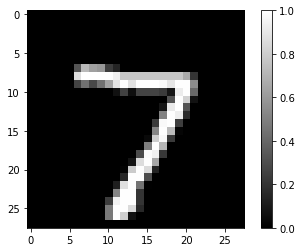

In [ ]:
show_image(x_test[0])

## 1.2 실제 내부 동작 구현 코드

In [ ]:
random_normal = tf.initializers.RandomNormal()

weights = {
    'h1': tf.Variable(random_normal([num_features, 128])),
    'h2': tf.Variable(random_normal([128, 256])),
    'out': tf.Variable(random_normal([256, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.zeros([128])),
    'b2': tf.Variable(tf.zeros([256])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [ ]:
def neural_net(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return tf.nn.softmax(out_layer)

In [ ]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

optimizer = tf.optimizers.SGD(learning_rate)

In [ ]:
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    trainable_variables = list(weights.values()) + list(biases.values())

    gradients = g.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
x_train.shape

(60000, 784)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [ ]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    #print(step, (batch_x, batch_y))
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 300, loss: 142.082260, accuracy: 0.785000
step: 600, loss: 38.360199, accuracy: 0.955000
step: 900, loss: 18.719881, accuracy: 0.990000
step: 1200, loss: 9.985777, accuracy: 0.990000
step: 1500, loss: 9.739521, accuracy: 0.995000
step: 1800, loss: 17.570957, accuracy: 0.985000
step: 2100, loss: 13.203381, accuracy: 0.975000
step: 2400, loss: 6.712338, accuracy: 0.995000
step: 2700, loss: 5.026523, accuracy: 1.000000
step: 3000, loss: 13.422650, accuracy: 0.995000


In [ ]:
# Test model on validation set.
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.970700


In [ ]:
y_test[4]

4

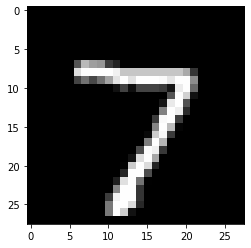

Model prediction: 7


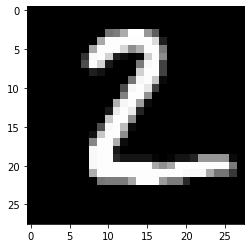

Model prediction: 2


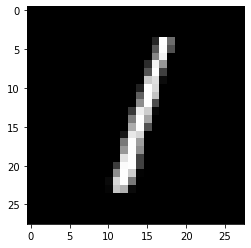

Model prediction: 1


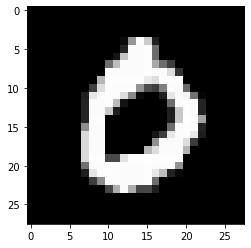

Model prediction: 0


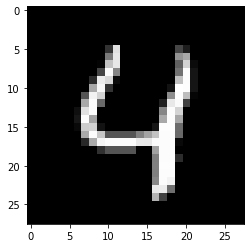

Model prediction: 4


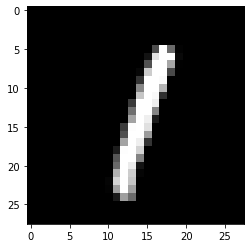

Model prediction: 1


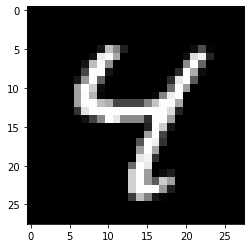

Model prediction: 4


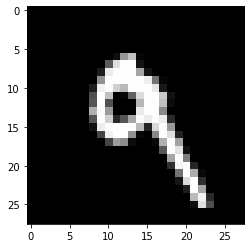

Model prediction: 9


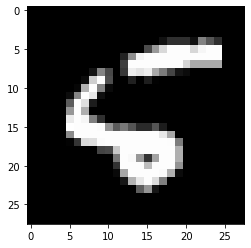

Model prediction: 5


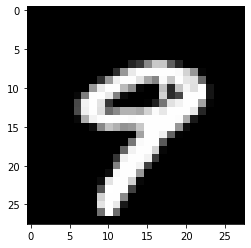

Model prediction: 9


In [ ]:
# Predict 5 images from validation set.
n_images = 10
test_images = x_test[:n_images]
predictions = neural_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

# 2. CNN을 활용한 MNIST 판별 모델

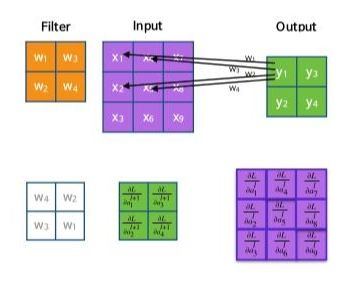

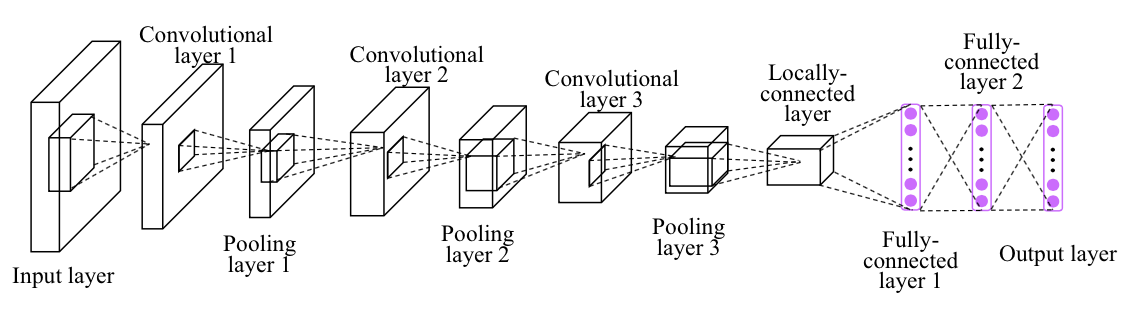

## 2.1 단순 모듈 활용

In [ ]:
num_classes = 10

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
y_train.shape

(60000,)

In [ ]:
input_shape = (28, 28, 1)
model_CNN = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1024),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

In [ ]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)             

In [ ]:
batch_size = 200
epochs = 10

model_CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_CNN.fit(x_train, keras.utils.to_categorical(y_train, num_classes), batch_size=batch_size, epochs=epochs)

Epoch 1/10
300/300 [==============================] - 10s 5ms/step - loss: 0.1752 - accuracy: 0.9464
Epoch 2/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0519 - accuracy: 0.9841
Epoch 3/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0365 - accuracy: 0.9886
Epoch 4/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0292 - accuracy: 0.9906
Epoch 5/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0240 - accuracy: 0.9921
Epoch 6/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0202 - accuracy: 0.9936
Epoch 7/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0177 - accuracy: 0.9944
Epoch 8/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0162 - accuracy: 0.9946
Epoch 9/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0135 - accuracy: 0.9956
Epoch 10/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0116 - accuracy: 0.996

In [ ]:
score = model_CNN.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes), verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.030841808766126633
Test accuracy: 0.9909999966621399


In [ ]:
predictions = model_CNN.predict(x_test)

In [ ]:
predictions[1]

array([1.2877505e-12, 3.4386369e-11, 1.0000000e+00, 5.3126038e-15,
       2.9108186e-14, 1.1287224e-22, 2.1209771e-15, 2.1543838e-13,
       8.9459825e-14, 7.8868778e-16], dtype=float32)

In [ ]:
np.argmax(predictions[1])

2

In [ ]:
y_test[1]

2

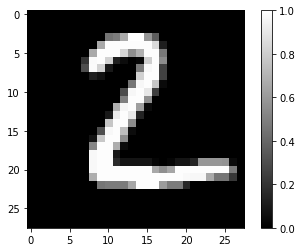

In [ ]:
show_image(x_test[1])

## 2.2 실제 내부 동작 코드 구현

In [ ]:
# Create TF Model.
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolution Layer with 32 filters and a kernel size of 5.
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        # Convolution Layer with 64 filters and a kernel size of 3.
        self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(1024)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
conv_net = ConvNet()

In [ ]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)


# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [ ]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = conv_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)
loss = 0
acc = 0
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 300, loss: 22.710428, accuracy: 0.965000
step: 600, loss: 7.377176, accuracy: 0.985000
step: 900, loss: 6.118070, accuracy: 0.995000
step: 1200, loss: 15.004663, accuracy: 0.980000
step: 1500, loss: 11.315936, accuracy: 0.980000
step: 1800, loss: 28.777655, accuracy: 0.955000
step: 2100, loss: 10.048088, accuracy: 0.990000
step: 2400, loss: 7.427126, accuracy: 0.985000
step: 2700, loss: 25.213274, accuracy: 0.985000
step: 3000, loss: 17.968426, accuracy: 0.970000


In [ ]:
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.975900


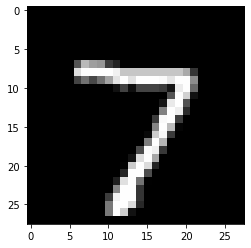

Model prediction: 7


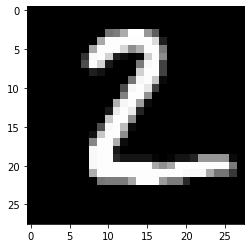

Model prediction: 2


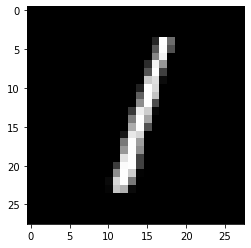

Model prediction: 1


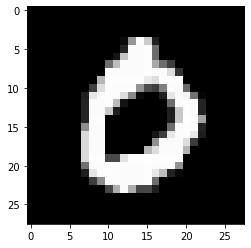

Model prediction: 0


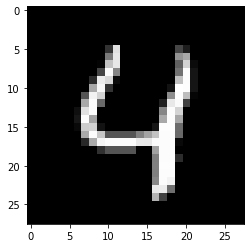

Model prediction: 4


In [ ]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = conv_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))